# Answer Matching Analysis

In [1]:
# ─── Path setup so `from reranker import Reranker` works ──────────────────────
import sys, os
# Set the environment variable for testing (remove this line in production!)
os.environ["MISTRAL_API_KEY"] = "GDTId8eQPtNGoVAhqkr5hel3mKqtoD1j"
# Resolve the directory that is one level above the notebook file
# (works whether you run from Jupyter Lab, VS Code, or plain IPython)
try:
    nb_dir = os.path.dirname(os.path.abspath(__file__))  # when executed as .py
except NameError:
    nb_dir = os.getcwd()                                 # when inside Jupyter

parent_dir = os.path.abspath(os.path.join(nb_dir, ".."))  # go one level up
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)                        # make it importable

# Now the normal import succeeds
from modules.retrieval.reranker import Reranker

In [2]:
# ─── Path hack so we can import project modules ─────────────────────────────
import sys, os, json, itertools, math, glob, random, time, collections
from pathlib import Path

nb_dir = Path.cwd()
parent  = (nb_dir / "..").resolve()
if str(parent) not in sys.path:
    sys.path.insert(0, str(parent))

# ─── Imports ────────────────────────────────────────────────────────────────
import time
import requests
import traceback
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sentence_transformers import SentenceTransformer, util
from modules.extraction.embedding import Embedding
from modules.retrieval.index.bruteforce import FaissBruteForce
from modules.extraction.preprocessing import DocumentProcessing


In [3]:
def query_mistral(prompt):
    """
    Calls the Mistral API and returns the response text.
    Returns None on non-200 responses or exceptions.
    """
    import requests, os, traceback

    api_key = os.getenv("MISTRAL_API_KEY")
    if not api_key:
        raise ValueError("MISTRAL_API_KEY is not set.")

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "mistral-medium",
        "messages": [{"role": "user", "content": prompt}]
    }

    try:
        response = requests.post(
            "https://api.mistral.ai/v1/chat/completions",
            json=payload, headers=headers, timeout=30
        )

        # Save response text for debugging
        with open("mistral_raw_response.log", "a", encoding="utf-8") as f:
            f.write(f"STATUS {response.status_code}\n{response.text}\n\n")

        if response.status_code != 200:
            print(f"[WARN] Mistral returned status {response.status_code}")
            return None

        try:
            parsed = response.json()
            content = parsed["choices"][0]["message"]["content"]
            return content.strip()
        except Exception as e:
            print("[ERROR] Failed to parse response JSON:")
            traceback.print_exc()
            print("[DEBUG] Raw response text:\n", response.text[:500])
            return None

    except Exception as e:
        print("[ERROR] Exception during API request:")
        traceback.print_exc()
        return None


In [4]:
# ---- Corpus ----------------------------------------------------------------
CORPUS_DIR = parent / "storage"
corpus_paths = list(CORPUS_DIR.glob("*.txt.clean"))
# ---- Load corpus safely (skip bad encodings) -------------------------------
corpus = []
bad_files = []

for p in corpus_paths:
    try:
        text = p.read_text(encoding="utf-8").strip()
        if text:
            corpus.append(text)
    except UnicodeDecodeError:
        # log and skip the problem file
        bad_files.append(p.name)
        print(f"[WARN] skipped {p.name} – bad UTF‑8 bytes")

print(f"Loaded {len(corpus)} docs  (skipped {len(bad_files)})")


print("Loaded", len(corpus), "docs.")

# ---- Questions, ground‑truth answers & difficulty --------------------------
qa_file = parent / "qa_resources" / "question.tsv"
qa_df   = pd.read_csv(qa_file, sep="\t").dropna(subset=["Question","Answer"])
print("Loaded", len(qa_df), "Q‑A pairs.")

# ---- Metrics ---------------------------------------------------------------
def exact_match(pred, truth):
    return int(pred.strip().lower() == truth.strip().lower())


import re

def normalize_answer(text):
    """
    Normalize an answer to its semantic core: yes/no/number/single token.
    """
    text = text.lower().strip()

    # yes/no detection
    if re.match(r'^(yes|yeah|yep|affirmative)[\W_]*', text):
        return "yes"
    if re.match(r'^(no|nope|nah|negative)[\W_]*', text):
        return "no"

    # number extraction
    match = re.match(r'^(\\d+)[\\W_]*$', text)
    if match:
        return match.group(1)

    # fallback to first word
    return text.split()[0] if text else ""


embedder_sim = SentenceTransformer("all-MiniLM-L6-v2")

def transformer_match(pred, truth, thresh=0.8):
    embeddings = embedder_sim.encode([pred, truth], normalize_embeddings=True)
    sim_score = float(util.cos_sim(embeddings[0], embeddings[1]))
    return int(sim_score >= thresh), sim_score


def f1_score(pred, truth):
    pred = normalize_answer(pred)
    truth = normalize_answer(truth)

    pred_tokens = set(pred.split())
    truth_tokens = set(truth.split())
    common = pred_tokens & truth_tokens

    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)






[WARN] skipped S08_set4_a8.txt.clean – bad UTF‑8 bytes
[WARN] skipped S09_set3_a2.txt.clean – bad UTF‑8 bytes
[WARN] skipped S09_set3_a6.txt.clean – bad UTF‑8 bytes
[WARN] skipped S09_set4_a8.txt.clean – bad UTF‑8 bytes
Loaded 146 docs  (skipped 4)
Loaded 146 docs.
Loaded 840 Q‑A pairs.


In [5]:
# ---- Config grid -----------------------------------------------------------
rerankers   = ["none", "bow", "tfidf", "cross_encoder", "hybrid", "sequential"]
chunk_sizes = [250, 500]          # characters for fixed‑length chunking
top_ks      = [5, 10, 20]

# ---- Build FAISS index once per chunk_size ---------------------------------
processor = DocumentProcessing()
results   = []
response_cache = {} 

for chunk_sz in chunk_sizes:
    # chunk & embed
    chunks, vectors = [], []
    embedder = Embedding("all-MiniLM-L6-v2")
    for doc in corpus:
        for chunk in processor.fixed_length_chunking_text(doc, chunk_size=chunk_sz):
            chunks.append(chunk)
            vectors.append(embedder.encode(chunk))
    index = FaissBruteForce(vectors[0].shape[0], metric="euclidean")
    index.add_embeddings(vectors, chunks)
    
    for top_k in top_ks:
            for _, row in qa_df.head(3).iterrows():          # only 5 Q‑A pairs
                q, gold, diff = row["Question"], row["Answer"], row["DifficultyFromQuestioner"]
    
                # ---------- retrieval ------------------------------------------------
                q_vec = embedder.encode(q)
                _, ids = index.search(q_vec, top_k)
                retrieved = [chunks[int(i)] for i in ids[0]]
    
                for rr_name in rerankers:
                    ranked = (retrieved if rr_name == "none"
                              else Reranker(type=rr_name).rerank(q, retrieved,
                                                                 seq_k1=top_k,
                                                                 seq_k2=top_k)[0])
    
                    ctx_block = "\n".join(ranked[:5])
                    cache_key = (q, ctx_block)
    
                    if cache_key in response_cache:
                        pred = response_cache[cache_key]
                    else:
                        prompt = (
                            "Use the following context to answer the question.\n\n"
                            f"Context:\n{ctx_block}\n\n"
                            f"Question: {q}\nAnswer:"
                        )
                        time.sleep(1)                      # rate‑limit back‑off
                        pred = query_mistral(prompt)
  
                        print("🔎 Mistral response preview:", pred[:150] if pred else "❌ No response")

                        response_cache[cache_key] = pred
                        #print("📤 Model answer:", pred[:150])
                        #print("📘 Gold answer:", gold[:150])

                    # ---------- skip failed calls ------------------------------------
                    if pred is None:          # e.g. 429 or other API error
                        continue              # do NOT append to results
                    # -----------------------------------------------------------------
                    
                    f1 = f1_score(pred, gold)

                    tm, tm_score = transformer_match(pred, gold, thresh=0.8)


                    
                    print("📝 PRED:", repr(pred.strip()[:200]))
                    print("🎯 GOLD:", repr(gold.strip()[:200]))
                    
                    results.append(dict(
                        reranker   = rr_name,
                        chunk_sz   = chunk_sz,
                        top_k      = top_k,
                        difficulty = diff,
                        tm         = tm,
                        tm_score   = tm_score,
                        f1         = f1
                    ))



🔎 Mistral response preview: Yes, Abraham Lincoln was the sixteenth President of the United States. He served from March 4, 1861 until his assassination on April 15, 1865.
📝 PRED: 'Yes, Abraham Lincoln was the sixteenth President of the United States. He served from March 4, 1861 until his assassination on April 15, 1865.'
🎯 GOLD: 'yes'
🔎 Mistral response preview: Yes, Abraham Lincoln was the sixteenth President of the United States. He served as president from March 4, 1861 until his assassination on April 15, 
📝 PRED: 'Yes, Abraham Lincoln was the sixteenth President of the United States. He served as president from March 4, 1861 until his assassination on April 15, 1865.'
🎯 GOLD: 'yes'
📝 PRED: 'Yes, Abraham Lincoln was the sixteenth President of the United States. He served as president from March 4, 1861 until his assassination on April 15, 1865.'
🎯 GOLD: 'yes'
📝 PRED: 'Yes, Abraham Lincoln was the sixteenth President of the United States. He served as president from March 4, 1861 u

In [6]:
res_df = pd.DataFrame(results)

agg = res_df.groupby(["reranker", "chunk_sz", "top_k"]).agg(
    tm=("tm", "mean"),
    tm_score=("tm_score", "mean"),
    f1=("f1", "mean")
).reset_index()


print(agg.head())           # should now show 'f1' column with float values


  reranker  chunk_sz  top_k   tm  tm_score        f1
0      bow       250      5  0.0  0.062509  0.666667
1      bow       250     10  0.0  0.082686  1.000000
2      bow       250     20  0.0  0.071174  1.000000
3      bow       500      5  0.0  0.045059  1.000000
4      bow       500     10  0.0  0.063813  1.000000


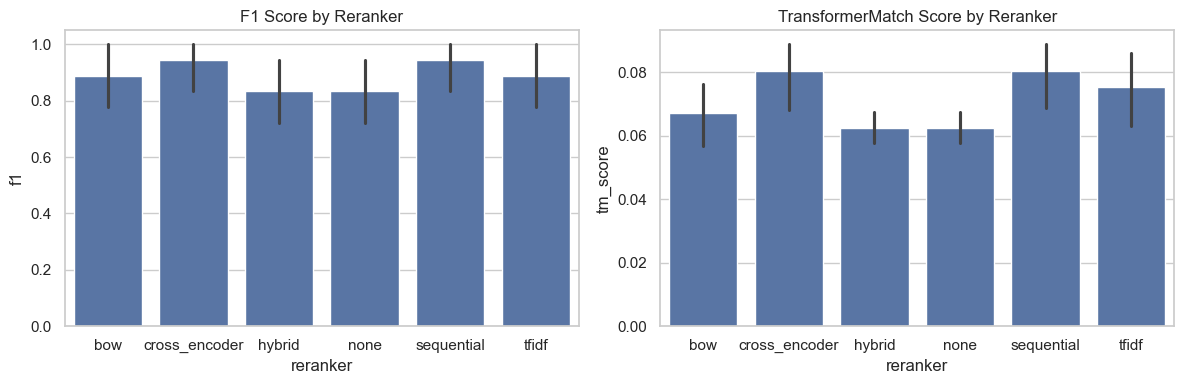

C:\Users\Putna\AppData\Local\Temp\ipykernel_42052\490310398.py:26: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Putna\.conda\envs\faiss\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


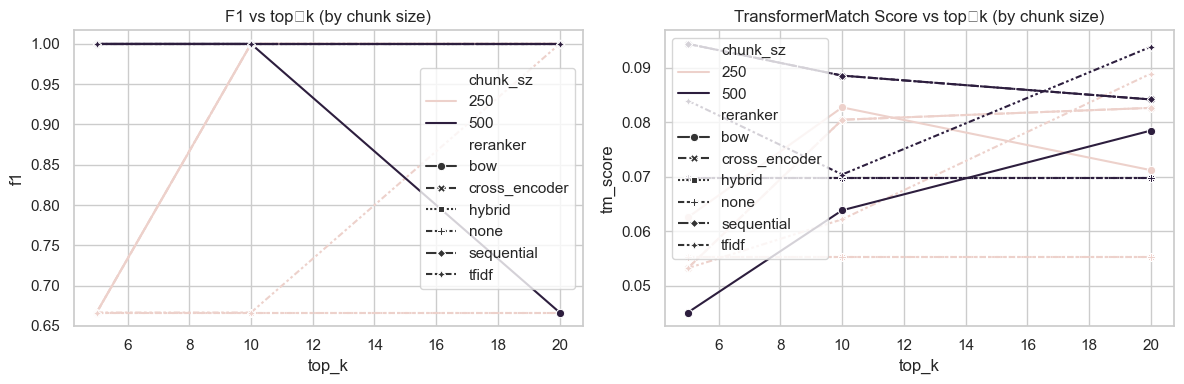

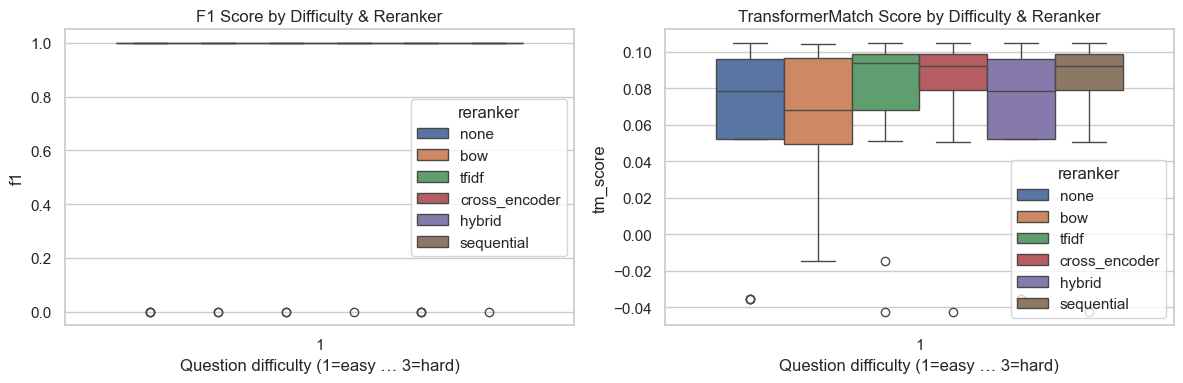

C:\Users\Putna\AppData\Local\Temp\ipykernel_42052\490310398.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retr_recall = res_df.groupby(["reranker", "chunk_sz", "top_k"]).apply(


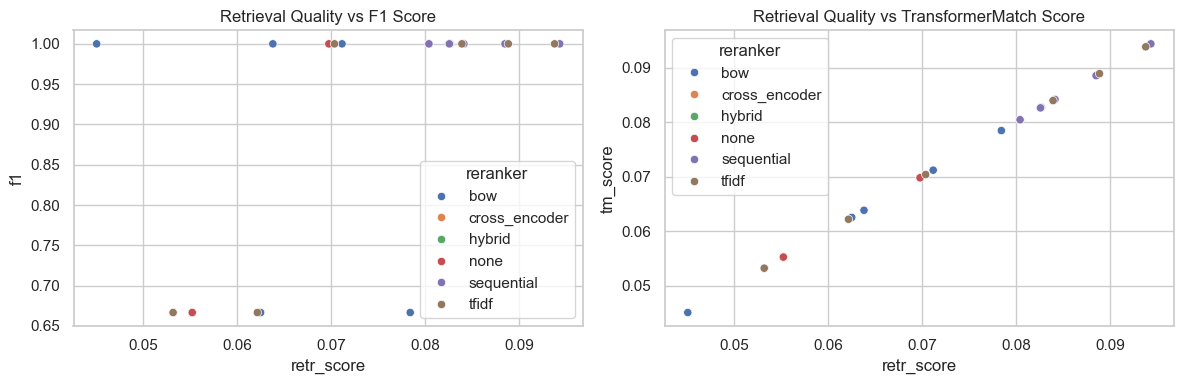

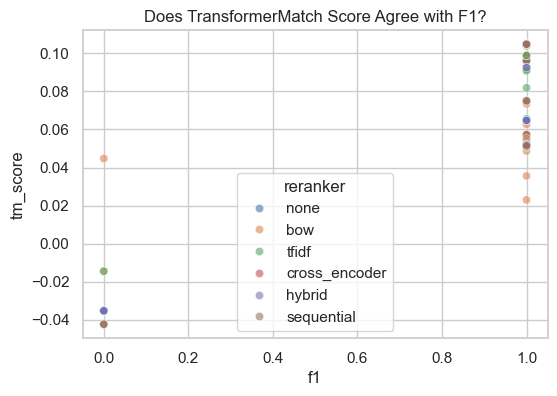

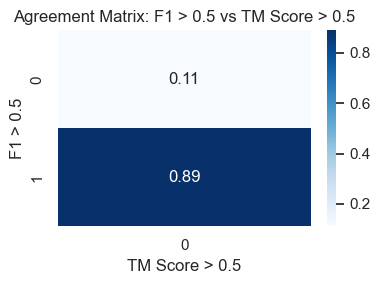

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# 1) F1 and TM Score by reranker ---------------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(data=agg, x="reranker", y="f1")
plt.title("F1 Score by Reranker")

plt.subplot(1, 2, 2)
sns.barplot(data=agg, x="reranker", y="tm_score")
plt.title("TransformerMatch Score by Reranker")
plt.tight_layout()
plt.show()

# 2) Chunk size & top‑k sweep ------------------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=agg, x="top_k", y="f1", hue="chunk_sz", style="reranker", markers=True)
plt.title("F1 vs top‑k (by chunk size)")

plt.subplot(1, 2, 2)
sns.lineplot(data=agg, x="top_k", y="tm_score", hue="chunk_sz", style="reranker", markers=True)
plt.title("TransformerMatch Score vs top‑k (by chunk size)")
plt.tight_layout()
plt.show()

# 3) Difficulty vs performance -----------------------------------------------
diff_map = {"easy": 1, "medium": 2, "hard": 3}
tmp = res_df.copy()
tmp["diff_num"] = tmp["difficulty"].map(diff_map)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=tmp, x="diff_num", y="f1", hue="reranker")
plt.xlabel("Question difficulty (1=easy … 3=hard)")
plt.title("F1 Score by Difficulty & Reranker")

plt.subplot(1, 2, 2)
sns.boxplot(data=tmp, x="diff_num", y="tm_score", hue="reranker")
plt.xlabel("Question difficulty (1=easy … 3=hard)")
plt.title("TransformerMatch Score by Difficulty & Reranker")
plt.tight_layout()
plt.show()

# 4) Retrieval recall vs generation performance ------------------------------
retr_recall = res_df.groupby(["reranker", "chunk_sz", "top_k"]).apply(
    lambda g: g["tm_score"].mean()
).reset_index(name="retr_score")

merged = pd.merge(agg, retr_recall, on=["reranker", "chunk_sz", "top_k"])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=merged, x="retr_score", y="f1", hue="reranker")
plt.title("Retrieval Quality vs F1 Score")

plt.subplot(1, 2, 2)
sns.scatterplot(data=merged, x="retr_score", y="tm_score", hue="reranker")
plt.title("Retrieval Quality vs TransformerMatch Score")
plt.tight_layout()
plt.show()

# 5) F1 vs TransformerMatch score agreement ----------------------------------
plt.figure(figsize=(6, 4))
sns.scatterplot(data=res_df, x="f1", y="tm_score", hue="reranker", alpha=0.6)
plt.title("Does TransformerMatch Score Agree with F1?")
plt.show()

# 6) Confusion matrix: F1 > 0.5 vs TM_Score > 0.5 -----------------------------
f1_binary = (res_df["f1"] > 0.5).astype(int)
tm_binary = (res_df["tm_score"] > 0.5).astype(int)

conf = pd.crosstab(f1_binary, tm_binary, normalize="all")

plt.figure(figsize=(4, 3))
sns.heatmap(conf, annot=True, fmt=".2f", cmap="Blues")
plt.title("Agreement Matrix: F1 > 0.5 vs TM Score > 0.5")
plt.xlabel("TM Score > 0.5"); plt.ylabel("F1 > 0.5")
plt.tight_layout()
plt.show()


## Discussion